In [1]:
 
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV # GridSearchCV for tuning
from sklearn.linear_model import LogisticRegression # Our focus model
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler # For handling imbalance
from collections import Counter # To check class distribution

import warnings
warnings.filterwarnings('ignore')


In [2]:

# Set the option to display the full content of columns
pd.set_option('display.max_colwidth', None)


In [ ]:
# --- Configuration ---
N_FEATURES_CHI2 = 5000 # Number of top features to select with Chi-Square (adjust based on vocab size)


In [4]:
# Ensure NLTK data is downloaded (run these once)
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4') # Open Multilingual Wordnet (required for WordNetLemmatizer)


### Load The dataset

In [5]:
df = pd.read_csv('It Support Ticket Data.csv',index_col=0)
df.head()


,Body,Department,Priority,Tags
0,"Dear Customer Support Team,I am writing to report a significant problem with the centralized account management portal, which currently appears to be offline. This outage is blocking access to account settings, leading to substantial inconvenience. I have attempted to log in multiple times using different browsers and devices, but the issue persists.Could you please provide an update on the outage status and an estimated time for resolution? Also, are there any alternative ways to access and manage my account during this downtime?",Technical Support,high,"['Account', 'Disruption', 'Outage', 'IT', 'Tech Support']"
1,"Dear Customer Support Team,I hope this message reaches you well. I am reaching out to request detailed information about the capabilities of your smart home integration products listed on your website. As a potential customer aiming to develop a seamlessly interconnected home environment, it is essential to understand how your products interact with various smart home platforms.Could you kindly provide detailed compatibility information with popular smart home ecosystems such as Amazon Alexa, Google Assistant, and Apple?",Returns and Exchanges,medium,"['Product', 'Feature', 'Tech Support']"
2,"Dear Customer Support Team,I hope this message finds you well. I am reaching out to request clarification about the billing and payment procedures linked to my account. Recently, I observed some inconsistencies in the charges applied and would like to ensure I fully understand the billing cycle, accepted payment options, and any potential extra charges.Firstly, I would be grateful if you could provide a detailed explanation of how the billing cycle functions. Specifically, I am interested in knowing the start and end dates.Thank you for your assistance regarding these billing inquiries.",Billing and Payments,low,"['Billing', 'Payment', 'Account', 'Documentation', 'Feedback']"
3,"Dear Support Team,I hope this message reaches you well. I am reaching out to ask about the compatibility of your products with the specific needs of marketing agencies. Our company is considering adopting these solutions to streamline our current marketing processes and wants to confirm that the products are fully compatible with the tools and platforms we currently utilize.Could you please supply detailed information regarding the compatibility of your products with popular marketing software, CRM systems, email marketing applications, and analytics platforms? Additionally, I would appreciate any relevant case studies or documentation tailored to our use case.",Sales and Pre-Sales,medium,"['Product', 'Feature', 'Feedback', 'Tech Support']"
4,"Dear Customer Support,I hope this message reaches you in good health. I am eager to learn more about the features of one of your products. Would you be able to share comprehensive details about its functionalities, specifications, and any distinctive characteristics it may possess? Additionally, if there are user manuals, tutorials, or demonstration videos available, I would be grateful if you could provide those resources. Gaining a thorough understanding of the features will assist me in making an informed decision regarding the product.Thank you very much for your assistance. I look forward to your prompt reply.Best regards",Technical Support,high,"['Feature', 'Product', 'Documentation', 'Feedback']"


In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

Body          0
Department    0
Priority      0
Tags          0
dtype: int64

In [8]:
departments = df['Department'].unique().tolist()

In [9]:
priority = df['Priority'].unique().tolist()[::-1]
priority  

['low', 'medium', 'high']

In [10]:
df.columns.tolist()

['Body', 'Department', 'Priority', 'Tags']

In [11]:
X = df['Body']
y_department = df['Department']
y_priority = df['Priority']

In [12]:
X

0                                                                                                                                                                                                                          Dear Customer Support Team,I am writing to report a significant problem with the centralized account management portal, which currently appears to be offline. This outage is blocking access to account settings, leading to substantial inconvenience. I have attempted to log in multiple times using different browsers and devices, but the issue persists.Could you please provide an update on the outage status and an estimated time for resolution? Also, are there any alternative ways to access and manage my account during this downtime?
1                                                                                                                                                                                                                                    Dear Customer S

In [13]:
# --- 2. Data Preprocessing ---
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text) # Remove non-alphabetic characters
    tokens = text.split() # Simple whitespace tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

print("\nStarting text preprocessing...")
X_preprocessed = X.apply(preprocess_text)
print("Text preprocessing complete.")
print("Sample preprocessed text (first entry):", X_preprocessed.iloc[0])




Starting text preprocessing...
Text preprocessing complete.
Sample preprocessed text (first entry): dear customer support teami writing report significant problem centralized account management portal currently appears offline outage blocking access account setting leading substantial inconvenience attempted log multiple time using different browser device issue persistscould please provide update outage status estimated time resolution also alternative way access manage account downtime


In [14]:
# --- 3. Encoding Output Columns (Department and Priority) ---
print("\nEncoding target columns (Department and Priority)...")
le_department = LabelEncoder()
y_department_encoded = le_department.fit_transform(y_department)
print(f"Original Departments: {le_department.classes_.tolist()}")
print(f"Encoded Departments (sample): {y_department_encoded[:5]}")

le_priority = LabelEncoder()
y_priority_encoded = le_priority.fit_transform(y_priority)
print(f"Original Priorities: {le_priority.classes_.tolist()}")
print(f"Encoded Priorities (sample): {y_priority_encoded[:5]}")



Encoding target columns (Department and Priority)...
Original Departments: ['Billing and Payments', 'Customer Service', 'General Inquiry', 'Human Resources', 'IT Support', 'Product Support', 'Returns and Exchanges', 'Sales and Pre-Sales', 'Service Outages and Maintenance', 'Technical Support']
Encoded Departments (sample): [9 6 0 7 9]
Original Priorities: ['high', 'low', 'medium']
Encoded Priorities (sample): [0 2 1 2 0]


In [15]:
y_target = y_department_encoded
y_target

array([9, 6, 0, ..., 9, 9, 0])

In [ ]:
# --- Split Data for TF-IDF Fitting and Model Training ---
# It's crucial to fit TF-IDF and Chi2 selector ONLY on the training data
# to prevent data leakage.
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_preprocessed, y_target, test_size=0.3, random_state=0.42, stratify=y_target
)
print(f"\nInitial data split for TF-IDF fitting: Training ({X_train_raw.shape[0]} samples), Testing ({X_test_raw.shape[0]} samples).")




Initial data split for TF-IDF fitting: Training (20755 samples), Testing (8895 samples).


In [17]:
# --- 4. Feature Engineering (TF-IDF) ---
print("\nStarting TF-IDF vectorization...")
# Experiment with max_features, min_df, ngram_range
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000, # Max number of features (words/ngrams)
    min_df=5,           # Ignore terms that appear in less than 5 documents
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw) # Only transform test data

print(f"TF-IDF vectorization complete. Training shape: {X_train_tfidf.shape}, Test shape: {X_test_tfidf.shape}")



Starting TF-IDF vectorization...
TF-IDF vectorization complete. Training shape: (20755, 10000), Test shape: (8895, 10000)


In [26]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1090748 stored elements and shape (20755, 10000)>

In [18]:
# --- 5. Dimensionality Reduction (Chi-Square) ---
print(f"\nStarting Chi-Square feature selection (k={N_FEATURES_CHI2})...")
selector = SelectKBest(chi2, k=min(N_FEATURES_CHI2, X_train_tfidf.shape[1])) # Ensure k is not greater than actual features

X_train_selected = selector.fit_transform(X_train_tfidf, y_train)
X_test_selected = selector.transform(X_test_tfidf) # Only transform test data

print(f"Chi-Square feature selection complete. New training shape: {X_train_selected.shape}, New test shape: {X_test_selected.shape}")



Starting Chi-Square feature selection (k=5000)...
Chi-Square feature selection complete. New training shape: (20755, 5000), New test shape: (8895, 5000)


In [ ]:
# --- 6. Handle Data Imbalance ---
# The paper mentions random oversampling and undersampling.
# We'll use RandomOverSampler for simplicity here.
# You might need to experiment with different strategies (e.g., SMOTE, combined over/undersampling).

print(f"\nOriginal training Department distribution: {Counter(y_train)}")

# Apply oversampling to the training data
ros = RandomOverSampler(random_state=0.42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_selected, y_train)

print(f"Resampled training Department distribution: {Counter(y_train_resampled)}")
print(f"Training data balanced. New shape: {X_train_resampled.shape}")

X_final_train = X_train_resampled
y_final_train = y_train_resampled
X_final_test = X_test_selected # Test set should NOT be resampled
y_final_test = y_test



Original training Department distribution: Counter({9: 6032, 5: 3877, 1: 3137, 4: 2450, 0: 2112, 6: 1027, 8: 810, 7: 619, 3: 398, 2: 293})
Resampled training Department distribution: Counter({9: 6032, 4: 6032, 6: 6032, 5: 6032, 8: 6032, 1: 6032, 2: 6032, 0: 6032, 7: 6032, 3: 6032})
Training data balanced. New shape: (60320, 5000)


In [22]:
# --- Evaluation Function ---
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    # Use 'weighted' average for precision, recall, fscore for multi-class imbalance
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    print(f"\n--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {fscore:.4f}")
    return accuracy, precision, recall, fscore


In [24]:

# --- 7. Model Training and Evaluation: Logistic Regression Only ---

print("\n--- Training Logistic Regression Classifier ---")

# Define parameter grid for GridSearchCV to tune Logistic Regression
# These parameters are crucial for getting good performance with TF-IDF
lr_param_grid = {
    'C': [0.1, 1, 10, 100], # Inverse of regularization strength; smaller C = stronger regularization
    'solver': ['liblinear', 'saga'], # 'liblinear' is good for small-to-medium datasets, 'saga' for L1/L2 and large datasets
    'max_iter': [500, 1000, 2000] # Increase max_iter if convergence warnings appear
}
# Initialize GridSearchCV
# cv=3 means 3-fold cross-validation
# verbose=1 shows progress
# scoring='f1_weighted' is good for imbalanced multi-class problems
lr_grid_search = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1), # n_jobs=-1 uses all available CPU cores
    lr_param_grid,
    cv=3,
    verbose=2, # More verbose output during search
    scoring='f1_weighted' # Optimize for F1-score, weighted for imbalance
)

# Fit GridSearchCV to find the best Logistic Regression model
print("Starting GridSearchCV for Logistic Regression...")
lr_grid_search.fit(X_final_train, y_final_train)

# Get the best estimator found by GridSearchCV
lr_classifier = lr_grid_search.best_estimator_
print(f"\nBest Logistic Regression parameters found: {lr_grid_search.best_params_}")

# Evaluate the best Logistic Regression model on the test set
evaluate_model(lr_classifier, X_final_test, y_final_test, "Logistic Regression (Tuned)")




--- Training Logistic Regression Classifier ---
Starting GridSearchCV for Logistic Regression...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ..............C=0.1, max_iter=500, solver=liblinear; total time=   1.3s
[CV] END ..............C=0.1, max_iter=500, solver=liblinear; total time=   1.7s
[CV] END ..............C=0.1, max_iter=500, solver=liblinear; total time=   1.7s
[CV] END ...................C=0.1, max_iter=500, solver=saga; total time=   1.3s
[CV] END ...................C=0.1, max_iter=500, solver=saga; total time=   1.1s
[CV] END ...................C=0.1, max_iter=500, solver=saga; total time=   1.2s
[CV] END .............C=0.1, max_iter=1000, solver=liblinear; total time=   1.5s
[CV] END .............C=0.1, max_iter=1000, solver=liblinear; total time=   1.6s
[CV] END .............C=0.1, max_iter=1000, solver=liblinear; total time=   1.7s
[CV] END ..................C=0.1, max_iter=1000, solver=saga; total time=   1.4s
[CV] END ..................C=0.

(0.5857223159078134,
 0.5911392321197044,
 0.5857223159078134,
 0.5870472994954834)


Classification Report for Logistic Regression:
                                 precision    recall  f1-score   support

           Billing and Payments       0.79      0.81      0.80       905
               Customer Service       0.52      0.54      0.53      1345
                General Inquiry       0.64      0.55      0.59       126
                Human Resources       0.69      0.63      0.66       170
                     IT Support       0.45      0.51      0.48      1050
                Product Support       0.54      0.55      0.54      1661
          Returns and Exchanges       0.52      0.61      0.56       440
            Sales and Pre-Sales       0.52      0.58      0.55       266
Service Outages and Maintenance       0.66      0.68      0.67       347
              Technical Support       0.65      0.57      0.61      2585

                       accuracy                           0.59      8895
                      macro avg       0.60      0.60      0.60      8895
 

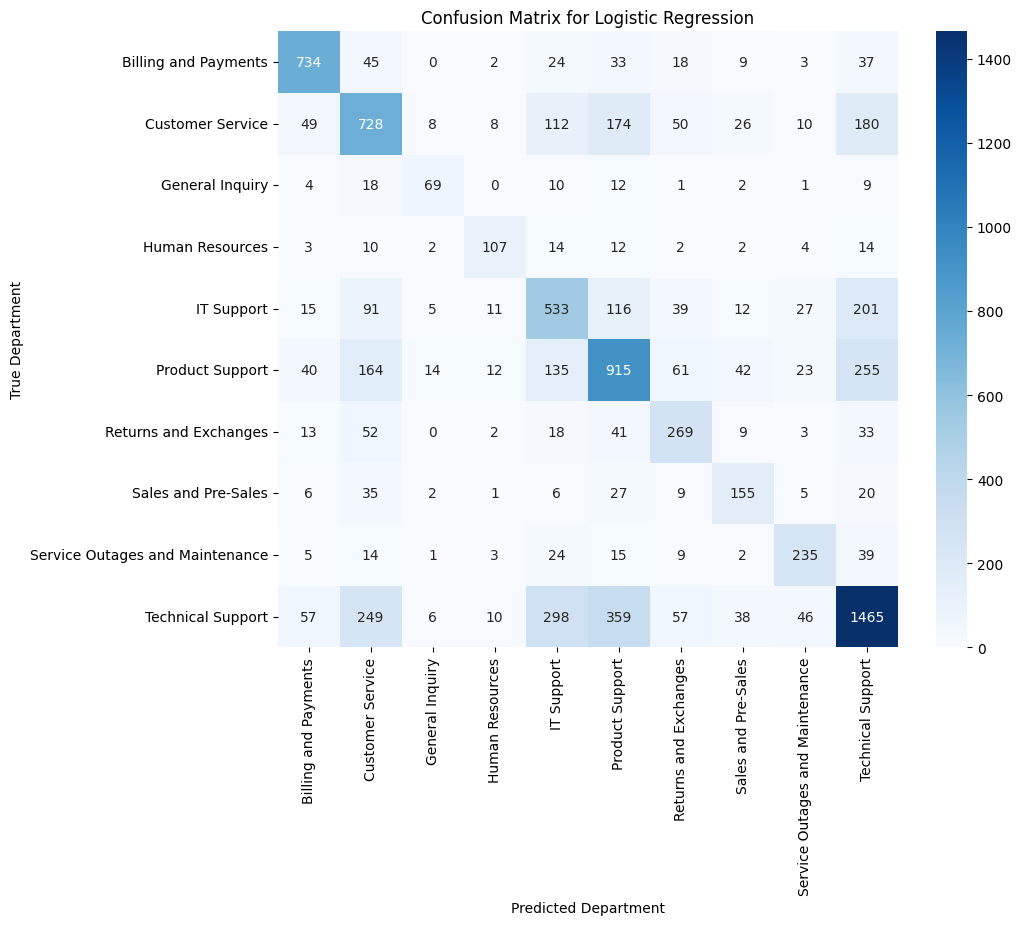

In [ ]:
from sklearn.metrics import classification_report
# Generate and print a detailed classification report
y_pred = lr_classifier.predict(X_final_test)    
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_final_test, y_pred, target_names=le_department.classes_, zero_division=0)) 

# show the classification report of predicted departments
print("\nClassification Report for Predicted Departments:") 
print(classification_report(y_final_test, y_pred, target_names=le_department.classes_, zero_division=0))

#  show the confusion matrix of predicted departments
from sklearn.metrics import confusion_matrix    
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_final_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_department.classes_, yticklabels=le_department.classes_)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Department')
plt.ylabel('True Department')
plt.show()



In [43]:
# show the classification report of predicted priorities
y_pred_priority = le_priority.inverse_transform(lr_classifier.predict(X_final_test))
print("\nClassification Report for Predicted Priorities:")  
print(classification_report(y_final_test, y_pred_priority, target_names=le_priority.classes_, zero_division=0))
# show the confusion matrix of predicted priorities
cm_priority = confusion_matrix(y_final_test, y_pred_priority)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_priority, annot=True, fmt='d', cmap='Blues', xticklabels=le_priority.classes_, yticklabels=le_priority.classes_)
plt.title('Confusion Matrix for Predicted Priorities')  
plt.xlabel('Predicted Priority')
plt.ylabel('True Priority')
plt.show()

ValueError: y contains previously unseen labels: [3 4 5 6 7 8 9]

### logistic Regression output
1. for Department :- 0.5121 => 51.21%
2. for Priority :- 0.5784 => 57.84